In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    data = list()
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('E:\\codes\\Python\\pionuia\\chest_xray\\train')
test = get_training_data('E:\\codes\\Python\\pionuia\\chest_xray\\test')
val = get_training_data('E:\\codes\\Python\\pionuia\\chest_xray\\val')

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4) /tmp/pip-req-build-21t5esfk/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
print(f"Train: {len(train)}, Test: {len(test)}")

Train: 5216, Test: 624


Text(0.5, 1.0, 'PNEUMONIA')

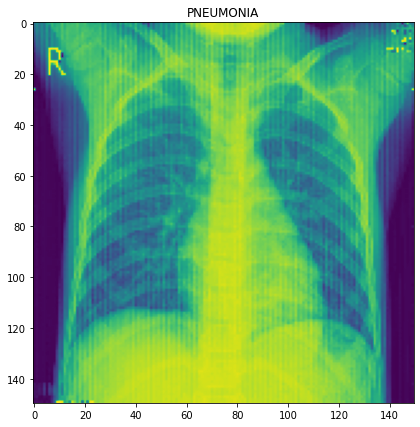

In [5]:
plt.figure(figsize = (7, 7))
plt.imshow(train[2][0])
plt.title(labels[train[2][1]])

In [16]:
def cross_validation(dataset):
    X_, y_= list(), list()
    for x, y in dataset:
        X_.append(x)
        y_.append(y)
    return X_, y_

def normalize(X):
    return np.array(X) / 255

def reshape(X, y, fig_size):
    X = X.reshape(-1, fig_size[0], fig_size[1], 1)
    y = np.array(y)
    return X, y

def data_argumentation(datagen=None):
    if datagen is None:
        return ImageDataGenerator(
                featurewise_center=False, 
                samplewise_center=False, 
                featurewise_std_normalization=False,  
                samplewise_std_normalization=False, 
                zca_whitening=False,  
                rotation_range = 30) 
    return datagen
    
    

In [17]:
X_train, y_train = cross_validation(train)
X_test, y_test = cross_validation(test)

X_train = normalize(X_train)
X_test = normalize(X_test)

X_train, y_train = reshape(X_train, y_train, (150, 150))
X_test, y_test = reshape(X_test, y_test, (150, 150))

In [18]:
datagenerator = data_argumentation(None)

In [19]:
datagenerator.fit(X_train)

In [20]:
def get_model(img_size):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=img_size))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides = 2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model

def get_callback():
    callbacks_list = [
            keras.callbacks.ModelCheckpoint(
                filepath='lstmchar256256128test.h5',
                monitor='val_loss',
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=8,
                mode='auto',
                baseline=None,
            )
        ]
    return callbacks_list

In [21]:
model = get_model((150, 150, 1))

2022-02-23 01:07:41.330829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:07:41.426467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:07:41.427207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 01:07:41.428370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
#model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])  
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [23]:
epochs=20
history = model.fit(datagenerator.flow(X_train, y_train, batch_size=32),
                    epochs=epochs, callbacks=get_callback())

2022-02-23 01:07:44.557909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-23 01:07:46.089885: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 16s 54ms/step - loss: 0.3113 - accuracy: 0.9030
Epoch 2/20
163/163 [==============================] - 9s 53ms/step - loss: 0.1324 - accuracy: 0.9498
Epoch 3/20
163/163 [==============================] - 9s 55ms/step - loss: 0.1180 - accuracy: 0.9590
Epoch 4/20
163/163 [==============================] - 9s 57ms/step - loss: 0.1097 - accuracy: 0.9607
Epoch 5/20
163/163 [==============================] - 9s 54ms/step - loss: 0.0993 - accuracy: 0.9657
Epoch 6/20
163/163 [==============================] - 9s 56ms/step - loss: 0.1003 - accuracy: 0.9641
Epoch 7/20
163/163 [==============================] - 9s 55ms/step - loss: 0.0996 - accuracy: 0.9691
Epoch 8/20
163/163 [==============================] - 9s 55ms/step - loss: 0.0867 - accuracy: 0.9695
Epoch 9/20
163/163 [==============================] - 9s 54ms/step - loss: 0.0817 - accuracy: 0.9728
Epoch 10/20
163/163 [==============================] - 9s 58ms/step - loss: 0.0806 - accuracy: 0.9730

In [ ]:
model.save('bestmodel.h5')

In [27]:
print(classification_report(y_test, classes_x, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.69      1.00      0.82       390
      NORMAL       1.00      0.25      0.40       234

    accuracy                           0.72       624
   macro avg       0.85      0.63      0.61       624
weighted avg       0.81      0.72      0.66       624

